##    Analyzing Climate Impact on Wine Production In Califonia Using Multidimentional Analysis

**This ArcGIS Notebook walks us through the steps in the [blog](https://www.esri.com/arcgis-blog/products/arcgis-pro/imagery/climate-impact-on-wine-using-notebooks/) of the same name.**

![title](images/blog_clip.png) 

----

### Tutorial Overview
This demonstration uses the [Multidimensional Analysis Capabilites](https://pro.arcgis.com/en/pro-app/latest/help/analysis/image-analyst/multidimensional-analysis-in-arcgis-pro.htm) in ArcGIS Pro to understand how climate may affect grape production in California.  

Using the **Daymet** variables of daily `Minimum` and `Maximum Temperature`, Annual Growing Degree Days (`GDD`) will be determined over the wine growing regions of California in order to evaluate areas suitability for grape production.  

##### Preparing the Daymet Data:  Esri's Cloud Ready Format

For this notebook, the **Daymet V4 Daily** data for variables `tmin` and `tmax` have been subset and clipped to California for 40 years (1980 - 2019) AND the netCDF files are [converted](https://www.esri.com/arcgis-blog/products/arcgis-pro/analytics/create-multidimensional-raster-data/) to Esri's `crf` format. 

- **`crf`** = cloud ready format  (Esri's native multidimentional raster format)

##### Analysis Workflow Outline

In the workflow, we will 
- compute `daily GDD` from the daily temperature variables, 
- aggregate daily GDD to `yearly GDD`, 
- classify regions using the [Winkler Index](https://en.wikipedia.org/wiki/Winkler_index),  
- and look for regional trends by computing statistics for each class across the 40 years
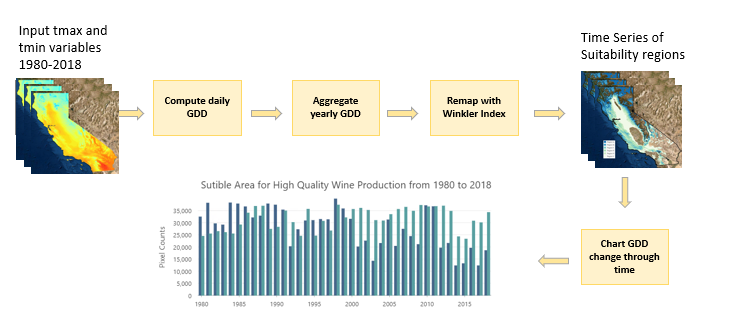

### Importing Esri Modules and Creating Raster Objects

**Import ArcPy and the image analysis module (arcpy.ia), which includes the APIs that we'll be using, and also check out the Image Analyst license, which is required by some functions**

In [1]:
import arcpy
import os
from arcpy.ia import *
arcpy.env.parallelProcessingFactor = "50%"   # parameter for parallel processing
arcpy.env.compression = "LERC 0.01"          # compression for output raster
arcpy.CheckOutExtension("ImageAnalyst")      # check out license
aprx = arcpy.mp.ArcGISProject("CURRENT")     # get Pro project current folder
arcpy.ResetEnvironments()
arcpy.env.workspace = r".\\"                 # define workspace

In [2]:
arcpy.env.workspace 

'\\p20'

**In this step, we are creating raster objects `tmin` and `tmax` from the input CRF files that are already available.  You can see that the raster objects created are Daymet Daily variables tmax and tmin and the dimension array equals 14,600 (40yrs x 365days); representing 40 years of daily temperature data, respectively.**

When working with multidimensional rasters, make sure to set the second parameter, `is_multidimensional`, to True, otherwise you will end up with a 2D raster.

In [3]:
#create raster objects from input tmax and tmin. each varaible contains 14600 slices of temperature data
tmax = arcpy.Raster(r"..\commondata\raster_data1\tmax_ca_5k.crf", True)
tmin = arcpy.Raster(r"..\commondata\raster_data1\tmin_ca_5k.crf", True)
print(tmax.variables)
print(tmin.variables)

['tmax(StdTime=14600)']
['tmin(StdTime=14600)']


In [ ]:
#tmax.mdinfo

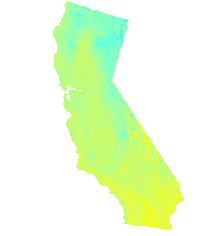

In [5]:
# to display a raster, get a single slice
tmax_oneslice = Subset(tmax, dimension_definitions={'StdTime':'2000-12-01T12:00:00'})
tmax_oneslice

### Calculate Daily Growing Degree Days

Growing Degree Days (GDD) is a measurement for estimating the growth and development of plants during the growing season, are normally used to predict when a crop will reach maturity. The basic concept is plant development will only occur if the temperature exceeds a minimum threshold, and a plant will only mature if total accumulated heat reaches a certain threshold that is required by the plant.

Daily `GDD` is calculated based on the maximum and minimum temperatures using this [formula](https://en.wikipedia.org/wiki/Growing_degree-day):

- **`GDD = max ((max_temperature + min_temperature) / 2 – base_temperature, 0)`**

- in our example below, we set the `base_temperature` equal to 10 degrees C

**Esri's `multidimensional algebra` makes the coding very simple. Using operators on multidimensional rasters, we can easily compute the `daily GDD` over 40 years.** 

Since the formula involves two rasters with different names, set an environment setting `matchMultidimensionalVariable` to False.

In [6]:
# Here we calculate GDD using multidimesional map algebra. 
# To enable the calculation with two rasters, we need to 
# set environment variable matchMultidimensionalVariable to be false
arcpy.env.matchMultidimensionalVariable = False
daily_GDD = (tmax + tmin) / 2 - 10
# only the positive GDD counts
non_negative_GDD = Con(daily_GDD < 0, 0, daily_GDD)

**We can select days in the growing season (gs) using logical time values defined within the crf file**
- We'll select from April 1 - October 31

In [7]:
# select days in the growing seasons(gs) from 
# beginning of April to End of October in each year
gs_daily_GDD = Subset(non_negative_GDD, \
                      dimension_definitions={'StdTime': ('1980-04-01T00:00:00', '1980-10-31T23:59:59', 1,'year')})
print(gs_daily_GDD.variables)
#gs_daily_GDD.mdinfo

['*(StdTime=8520)']


### Calculate Yearly Accumluated GDD

To calculate the `total GDD` of the growing season for each year, use the **`Aggregate`** function from the Image Analyst Toolset.  We can then save the process result as a CRF file. 

- Image Analyst has several geoprocessing processing tools that work with multidimensional data

**`Aggregate`** Generates a multidimensional raster dataset by combining existing multidimensional raster variables along a dimension, in this case `StdTime`.

Due to time, **We won't run** this block during the webinar, but have saved the output file from a previous run.  We'll use that in the next step.
- keep in mind this step is aggregating **daily** data over a 40 year period, so it will take a little while to run

In [ ]:
#### DO NOT RUN DURING WEBINAR ###
## Aggregate daily GDD to yearly using Aggregate function and save the data ##

## Uncomment this code to run ##
#yearly_GDD = arcpy.ia.Aggregate(gs_daily_GDD, 'StdTime', 'Sum', None, \
#                                aggregation_definition={'interval': 'yearly'})
#yearly_GDD.save(".\yearly_gdd.crf")

**We'll create a raster object and display the `yearly_GDD here`, but can also view it on the Map pane** 

Notice that we now have 40 time steps; the 40 years of data.

['*(StdTime=40)']


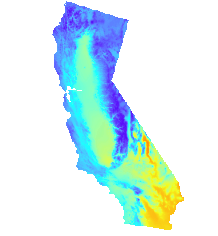

In [8]:
#display yearly_GDD result
#yearly_GDD = arcpy.Raster(".\yearly_gdd.crf", True)
yearly_GDD = arcpy.Raster(r"..\commondata\raster_data\final\yearly_gdd.crf", True)
print(yearly_GDD.variables)
yearly_GDD
#yearly_GDD.mdinfo

### Winkler index (https://en.wikipedia.org/wiki/Winkler_index)
The Winkler Index is a technique for classifying the climate of wine growing regions based on the annual growing degree-days.  In the Winkler definitions, climate regions are classified as follows.
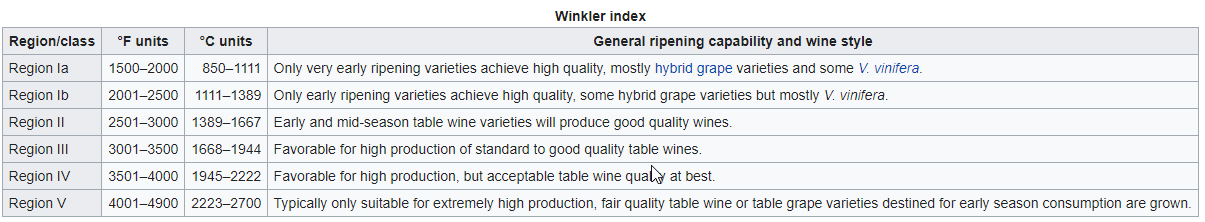

**Apply the Winkler Index by using the `Remap` raster function to remap the Yearly GDD ranges into six classes with values from 1 to 6.**

##### We will now have a multidimensional raster with values from 1 to 6 representing the six suitability regions.

Like the other raster files, this will be added to the map frame.

In [9]:
#remap yearly GDD into 6 classes using Winkler index
#yearly_GDD = arcpy.Raster(".\yearly_gdd.crf", True)
remap_yearly_GDD = Int(Remap(yearly_GDD, input_ranges=[840,1111,1111,1389,1389,1667,1667,1944,1944,2222,2222,2700], output_values=[1,2,3,4,5,6], allow_unmatched=False))

### Associate the six regions with Class Name (eg. Region 1a) and Color Ramp

We've already created a CSV file, **`grape_classes_table.csv`** (we can view this from the map pane), to associate the region Values with `ClassName`. The table also contains a display color for each region.

Using the **`Raster Attribute Table`** function, we'll apply the table to the suitabilty region raster created above: `remap_yearly_GDD`.  

- Use the ArcPy function **`Apply`**.  
- `Apply` is an ArcPy function designed for processing using raster functions in the ArcPy environment.  In this code block, 'Table' is the **Raster Attribute Table** function, and it takes a **RecordSet** as an argument.  

- The result is a time series of wine suitability region classification for 1980 - 2019.

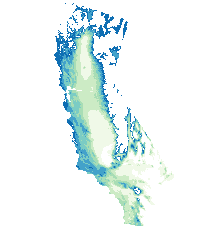

In [10]:
#persist data with class definition 
record_set = arcpy.RecordSet()
record_set.load(r"..\commondata\input\grape_classes_table.csv")
class_raster = arcpy.ia.Apply(remap_yearly_GDD, 'Table', {'AttributeTableAsRecordSet':record_set})
#class_raster.save(".\yearly_Winkler_class.crf")
class_raster

### We can view this yearly_Winkler_class raster on the MAP pane

### Statistics of the Suitability Classes

We'll use the **`SummarizeCategoricalRaster`** geoprocessing tool to calculate the areas of the `wine-class regions`, for each year.  
- The output `table` contains pixel counts for all region classes across all years

In [11]:
#calculate class summary statistics using SummarizeCategoricalRaster tool
#summary_table_name = r".\WineSutability.gdb\summary_class"
summary_table_name = os.path.join(aprx.defaultGeodatabase, "summary_class")
summary_table = arcpy.ia.SummarizeCategoricalRaster(class_raster, summary_table_name)

**And finally, we'll use the ArcPy `Chart` class to display the trend in two classes**

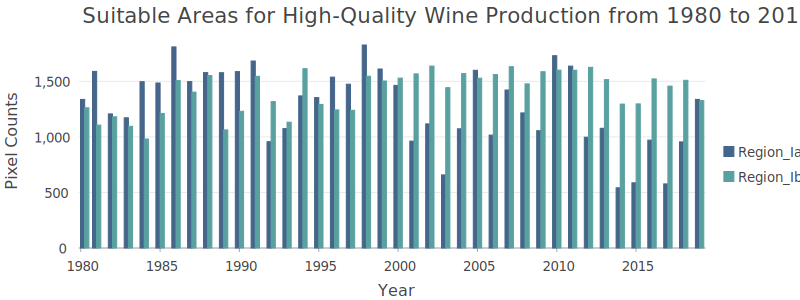

In [12]:
#create a chart
summary_table = os.path.join(aprx.defaultGeodatabase, "summary_class")
table = arcpy.mp.Table(summary_table)
c = arcpy.Chart('Winkler Grape Suitibility Chart')
c.type = 'bar'
c.title = 'Suitable Areas for High-Quality Wine Production from 1980 to 2019'
c.xAxis.field = 'StdTime'
c.xAxis.title = 'Year'
c.yAxis.title = "Pixel Counts"
c.displaySize = (800, 300)
c.bar.aggregation = 'SUM'
c.yAxis.field = ['Region_Ia', 'Region_Ib']
c.color = ['#45668A', '#59A0A1']
c.dataSource = table
c

### Summary

The chart suggests that Region_Ia, total areas (pixel counts) suitable for early ripened, high-quality grapes, are declining — which means that premium wines produced from these areas might be affected by the changing climate. The total pixel counts for Region_Ib and other classes do not show a big change over the years.